In [2]:
import glob, os, json, re, unicodedata
from bs4 import BeautifulSoup

load_verbose = 0
loaded_labels = []
loaded_text = []
labels = {"Barack Obama": 0,
          "Donald J. Trump": 1,
          "Dwight D. Eisenhower": 2,
          "Franklin D. Roosevelt": 3,
          "George Bush": 4,
          "George W. Bush": 5,
          "Gerald R. Ford": 6,
          "Harry S. Truman": 7,
          "Herbert Hoover": 8,
          "Jimmy Carter": 9,
          "John F. Kennedy": 10,
          "Lyndon B. Johnson": 11,
          "Richard Nixon": 12,
          "Ronald Reagan": 13,
          "William J. Clinton": 14}

# load raw text files straight in, no parsing
directory = "../data/processed/"
file_to_label = {"Obama": "Barack Obama", "Trump": "Donald J. Trump"}
for filename in glob.glob(os.path.join(directory, '*.txt')):
    arr = filename.replace(directory,'').split("_")
    loaded_labels = loaded_labels + [labels[file_to_label[arr[0]]]]
    raw = open(filename).read().decode("UTF-8").encode("ascii","ignore")
    loaded_text = loaded_text + [raw] 
        
# load JSON text files; parsing into raw text
directory = "../data/unprocessed/"
for filename in glob.glob(os.path.join(directory, '*.json')):
        json_data=open(filename)
        data = json.load(json_data)
        json_data.close()
        for data2 in data["speeches"]:
            if ('News Conference With' not in data2['name']):
                # data2['text'] has a lot of htmtl tags in there. We still need to parse it            
                raw = BeautifulSoup(data2['text'], "html.parser").get_text(" ")
                raw = unicodedata.normalize('NFKD', raw).encode('ascii','ignore')
                # Remove []
                raw = re.sub(' \[.*?\]',' ', raw, flags=re.DOTALL)
                # Remove ()
                raw = re.sub(' \(.*?\)',' ', raw, flags=re.DOTALL)
                # Removing the questions
                raw = re.sub('[A-Z,\s,\.]Q\..*? The President\.','\.',raw, flags=re.DOTALL)
                raw = re.sub('^[A-Z,\s]*THE PRESIDENT\.','',raw, flags=re.DOTALL)
                raw = re.sub('[A-Z,\s,\.]Q\..*?THE PRESIDENT\.','\.',raw, flags=re.DOTALL)
                
                # capture speaker (i.e., label)
                speaker = data2['speaker']
                
                # push speaker and text
                if (load_verbose == 1):
                    print "Loading: ", data2['speaker'], "(", labels[speaker], "), ", data2['name']
                loaded_labels = loaded_labels + [labels[speaker]] 
                loaded_text = loaded_text + [raw]

print "Loaded", len(loaded_text), "speeches for", len(set(loaded_labels)), "presidents."

Loaded 1750 speeches for 15 presidents.


In [3]:
#
# Bagnall 2015 text pre-processing
#
from string import maketrans
import re

chars_to_replace = "[]%!()>=*&_\n"
sub_chars = len(chars_to_replace) * " "
trantab = maketrans(chars_to_replace, sub_chars)
for x in range(0,len(loaded_text)):
    #"Various rare characters that seemed largely equivalent are mapped together..."
    loaded_text[x] = re.sub('`', '', loaded_text[x])
    #"...all digits in all languages are mapped to 7"
    loaded_text[x] = re.sub('[0-9]', '7', loaded_text[x])
    #"...any character with a frequency lower than 1 in 10,000 is discarded." (+ \n)
    loaded_text[x] = loaded_text[x].translate(trantab)
    #"Runs of whitespace are collapsed into a single space."
    loaded_text[x] = re.sub(' +', ' ', loaded_text[x])

In [4]:
#
# Summary stats
#
max_speech_len_char = (len(max(loaded_text, key=len)))
average_speech_len_char = sum( map(len, loaded_text) ) / len(loaded_text)
min_speech_len_char = min( map(len, loaded_text) ) 

print "Maximum speech length in characters:", max_speech_len_char
print "Average speech length in characters:",  average_speech_len_char
print "Minimum speech length in characters:",  min_speech_len_char

Maximum speech length in characters: 71563
Average speech length in characters: 15727
Minimum speech length in characters: 240


In [5]:
from sklearn.cross_validation import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

# Tokenize into characters
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(loaded_text)
tokenized_text = tokenizer.texts_to_sequences(loaded_text)

sorted(((v,k) for k,v in tokenizer.word_counts.iteritems()), reverse=True)

//anaconda/envs/keras_tf/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[(4916468, ' '),
 (2686419, 'e'),
 (2202084, 't'),
 (1684121, 'o'),
 (1663050, 'a'),
 (1546864, 'n'),
 (1462636, 'i'),
 (1244214, 's'),
 (1215534, 'r'),
 (1103252, 'h'),
 (777328, 'l'),
 (739451, 'd'),
 (569043, 'u'),
 (561594, 'c'),
 (493729, 'm'),
 (435258, 'w'),
 (404511, 'f'),
 (402137, 'g'),
 (396043, 'p'),
 (392106, 'y'),
 (325347, '.'),
 (291757, 'b'),
 (277412, ','),
 (245928, 'v'),
 (181885, 'I'),
 (154337, 'k'),
 (116402, '7'),
 (100023, "'"),
 (78875, 'A'),
 (75299, 'T'),
 (65550, 'S'),
 (47162, '-'),
 (44748, 'W'),
 (42118, 'P'),
 (41635, 'N'),
 (41221, 'C'),
 (37484, 'E'),
 (34662, 'x'),
 (34477, '\\'),
 (30788, 'M'),
 (27464, 'j'),
 (27288, 'B'),
 (26570, 'R'),
 (24436, 'H'),
 (22821, 'O'),
 (22289, 'q'),
 (22235, 'G'),
 (21898, 'D'),
 (17962, ':'),
 (16989, 'U'),
 (15184, 'F'),
 (14476, '"'),
 (13473, 'L'),
 (12439, '?'),
 (12427, 'z'),
 (11858, 'J'),
 (10911, 'Y'),
 (10660, ';'),
 (8738, '/'),
 (5427, 'V'),
 (5271, 'K'),
 (4764, 'Q'),
 (4067, '$'),
 (513, 'Z'),
 (435, '

In [21]:
def splits(_list, _split_size):
    output_list = []
    for idx in range(0, len(_list), _split_size):
        if (idx + _split_size) <= len(_list):
            output_list.append(_list[idx:idx + _split_size])
    return output_list

max_seq_len = 100

# create new speech/label holders
split_text = []
split_labels = []

for idx in range(0, len(tokenized_text)):
    current_label = loaded_labels[idx]
    current_speech = tokenized_text[idx]
    current_splits = splits(current_speech, max_seq_len)
    split_text.extend(current_splits)
    split_labels.extend([current_label] * len(current_splits))

print len( split_text )
print len( split_labels )

274354
274354


In [22]:
import numpy as np
from keras.utils import to_categorical

# note that max sentence length here is char NOT word
max_chars = len(tokenizer.word_counts)

X = []

# reshape split_text to be [samples, time steps, features]
X = np.reshape(split_text, (len(split_text), max_seq_len, 1))

# one-hot encode classes
y = to_categorical(split_labels)

train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.8, random_state=45)

print "Prepared training (", len(train_X), "records) and test (", len(test_X), "records) data sets."

Prepared training ( 219483 records) and test ( 54871 records) data sets.


In [23]:
#custom activation described in Bagnall 2015
import tensorflow as tf

def ReSQRT(x):
    cond = tf.less(x, 0)
    result = tf.where(cond, x + 0.0, tf.sqrt(x+1)-1)
    return result

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, SimpleRNN, Dropout, LSTM
from keras.optimizers import adagrad, adam, adamax, rmsprop

batch_size = 1000
epochs = 20

model = Sequential()
model.add(SimpleRNN(200, activation="relu", input_shape=(train_X.shape[1], train_X.shape[2]), dropout=0.5)) 
model.add(Dense(15, activation='softmax'))

# The network is trained using a variant of adagrad...
optimizer = adagrad(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])
print(model.summary())

model.fit(train_X, y=train_y, batch_size=batch_size, epochs=epochs, verbose=1)

# Loss function: 
# Drop-out: 0
# Learning rate: < 0.01
# Optimizers: x

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_9 (SimpleRNN)     (None, 200)               40400     
_________________________________________________________________
dense_9 (Dense)              (None, 15)                3015      
Total params: 43,415
Trainable params: 43,415
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
  3000/219483 [..............................] - ETA: 187s - loss: 4.0015 - categorical_accuracy: 0.1073

In [98]:
# Evaluate performance
print "Evaluating test data..."
loss_and_metrics = model.evaluate(test_X, test_y)
print model.metrics_names
print loss_and_metrics

# Make some predictions
print "\nPredicting using test data..."
pred_y = model.predict(test_X, batch_size=batch_size, verbose=1)
pred_y_collapsed = np.argmax(pred_y, axis=1)
test_y_collapsed = np.argmax(test_y, axis=1)

print "Done prediction."

Evaluating test data...
160/160 [==============================] - 0s     
['loss', 'categorical_accuracy']
[3.9829726696014403, 0.03125]

Predicting using test data...
160/160 [==============================] - 0s     
Done prediction.


Confusion matrix, without normalization
[[0 0 1 1 0 0 0 1 0 2 2 0 0 1 3]
 [1 1 0 1 0 0 0 2 0 0 0 0 0 0 1]
 [0 0 0 0 0 3 2 0 1 0 3 2 0 0 0]
 [0 0 1 1 0 2 0 1 0 1 2 1 0 1 1]
 [5 0 0 2 0 2 2 3 0 0 1 0 0 1 1]
 [0 0 0 0 0 0 2 0 1 0 1 3 0 0 0]
 [2 0 1 1 0 1 0 1 0 0 2 1 0 0 1]
 [0 0 0 0 1 1 0 0 2 1 1 5 1 0 2]
 [1 0 2 2 1 1 0 2 1 1 0 1 0 0 2]
 [3 0 0 3 0 0 0 0 2 3 0 1 1 1 0]
 [0 0 0 2 1 0 0 1 0 0 0 4 0 0 0]
 [3 0 0 1 0 0 0 0 2 3 0 1 0 0 1]
 [0 0 3 1 0 0 1 0 0 1 0 0 0 1 1]
 [0 0 0 2 0 1 1 0 0 1 1 0 1 0 1]
 [0 0 2 2 0 1 1 1 0 0 1 1 0 0 1]]


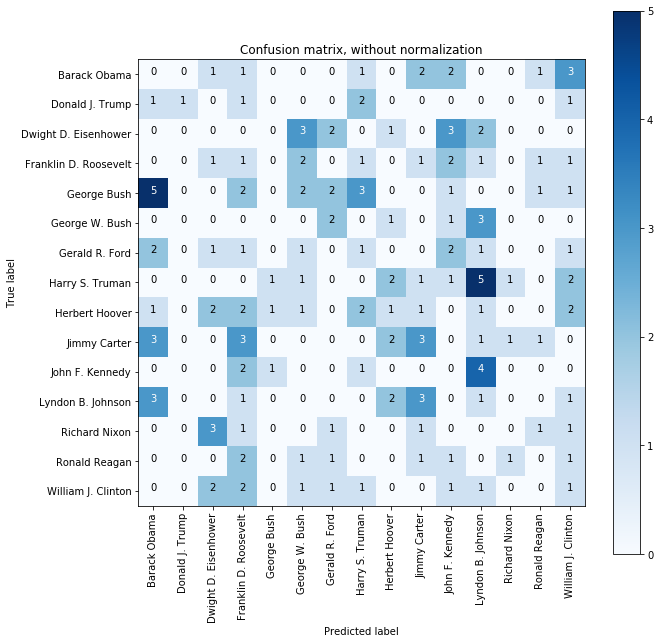

In [94]:
# from scikit-learn examples @
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html 
%matplotlib inline
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_y_collapsed, pred_y_collapsed)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=(sorted(labels, key=labels.get)),
                      title='Confusion matrix, without normalization')

# #Plot normalized confusion matrix
# plt.figure(figsize=(10,10))
# plot_confusion_matrix(cnf_matrix, classes=(sorted(labels, key=labels.get)), normalize=True,
#                       title='Normalized confusion matrix')

plt.show()